# Introduction

The goal of [LongEval-Classification Subtask B of CLEF 2022 Task 2](https://clef-longeval.github.io/) is to propose a temporal persistence classifier which can mitigate performance drop over short and long periods of time compared to a test set from the same time frame as training.

Given a test set from the same time frame as training and evaluation sets from short/long time periods, the task is to design a classifier that can mitigate short/long term performance drops.

The organizers will provide a training set collected over a time frame up to a time t and two test sets: test set from time t and test set from time t+i where i=1 for sub-task A and i>1 for subtask B.

*  ***Sub-task short-term persistence.*** In this task, participants will be asked to  develop models that demonstrate performance persistence over short periods of time (within 1 year from the training data).

*  ***Sub-task long-term persistence.*** In this task, participants will be asked to develop models that demonstrate performance persistence over a longer period of time (over 1 year apart from the training data).

This notebook provides a baseline for each setting in [LongEval-Classification Subtask B of CLEF 2022 Task 2](https://clef-longeval.github.io/).  
Please start by stepping through this notebook so you have a clear idea as to what is expected of the task and what you need to submit. 
These baselines are based on the results described in the paper “[Building for Tomorrow: Assessing the Temporal Persistence of Text Classifiers](https://arxiv.org/abs/2205.05435)”. 


### *Model-centric approches*
Participants in this setting are expected to design an experimental architecture to enhance a sentiment text classifier's temporal performance persistence. Participants are asked to evaluate their models in this environment without adjusting them for target years' timing. With a focus on **hyperparameter tuning and objective function optimization** techniques, this will enable the model to be ranked based on its short- and long-term persistence.

### *Data-centric approaches*
Participants in this setting are expected to design a data-centric experimental design to fine-tune a sentiment text classifier's expected to classifay new evolving testing sets. Participant are permitted to use **supervised/unsupervised time-specific approaches**. However, all data-centric systems should be evaluated using all three testing sets though insuring consistency i.e. if participant are goting to use a classifier tuned using one year, then should this be evaluted using all the testing sets.

For this setting, additionally fine-tune on the unsupervised longitudinal data provided :“[unannotated sentiment dataset](http://tweetnlp.org/downloads/sample-10k-monthly-120k-yearly.jl.zip)”.


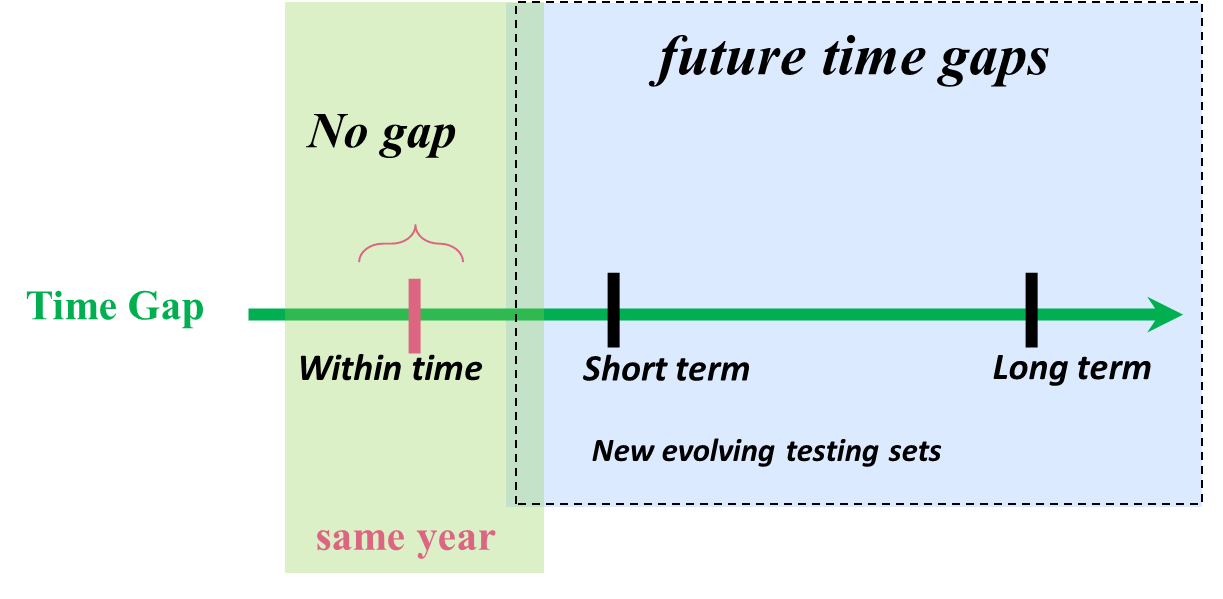

Where **Time Gap** is the different in time between test and training time frames i.e. when testing year = 2014 and train year = 2013 then Time Gap = +1 similarly when testing and traning from same time frame then Time Gap = 0 as in within-time testing set.


In this shared task we aim to rank models based on their performance separately for within time (testing year == train year) , short term and long term (testing year > train year). This will allow us to see if one model is more persistance overtime though placing first rank in all longitudinal datasets.



# Evaluation
The submissions will be ranked by ***macro F1-score*** separately for within, short and long term datasets, though winner systems are the one ranked top using averaged results over all testing sets. The metrics will be computed as follows:
* **Macro F1-Score** for each individual submission for: within, short and long testing sets [Check scikit-learn implementaions](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) 


```
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')
```

* **Relative Performance Drop (RPD)** for short and long term datasets compared to within testing set adopted from prior work “[Opinions are Made to be Changed: Temporally Adaptive Stance Classification
](https://dl.acm.org/doi/10.1145/3472720.3483620)”. 

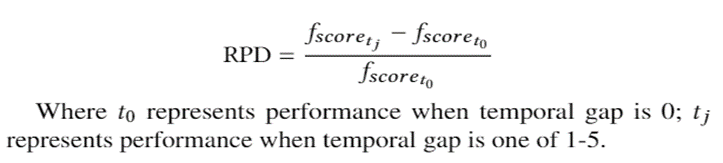
```
def calculate_RPD (temporal_fscore, within_fscore):
    RPD = (temporal_fscore -  within_fscore) / within_fscore
    return RPD
```

This it to quantify drop by comparing [within with short] and [within with long] to see if performance of 'within time' is a good quantifier for model's robustness evaluation. 

* **Average macro f1-score** for all three submissions [within, short and long]


# Starting Kit and baseline code
This is a Starter Kit that includes our proposed baseline model which is a model-centric approch. The results described in the paper "[Building for Tomorrow: Assessing the Temporal Persistence of Text Classifiers](https://arxiv.org/abs/2205.05435) serve as the base for the model settings.

This starter kit can be used to run or compare performance with the proposed system, as well as to classify the evaluation set.

**Task 2:** `[This is a TensorFlow-based Python code implemented with the hugging-face library's roberta-base]`


*Note:* when your develop you own system, make sure that evaluation results are submitted for **all three held-out testing sets**.

#### **First:** to maintain consistency every run will have its own run id

In [ ]:
import logging

logger = logging.getLogger('Task 2 ## ')
logger.info(
    "This is the performance record for all selected models evaluated over all held-out evaluation and testing sets. ")
team_name = 'CLEFLongEvalTask2_team2023'
logger.info("team name : {}".format(team_name))
import uuid

run_id = str(uuid.uuid1())

print("The run id using uuid1() is : ", end="")
print(run_id)

model_discribtion = ' Baseline model - Roberta base with distantly labled train, with eval [interim_eval_2016] and distant eval [interim_eval_2018]'

logging.basicConfig(filename='PerformanceRecordOfSelectedModels' + run_id + '.log', filemode='a',
                    format='%(name)s - %(levelname)s - %(message)s', force=True, level=logging.INFO)

logger.info("The run id using uuid1() is : {} ".format(str(run_id)))
logger.info("<Model's discribtion : {} ".format(str(model_discribtion)))

#### **Second:** using pip to install additional libraries and imports

In [ ]:
!pip install transformers
!pip install tf-models-official==2.4.0

In [ ]:
import math
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import tensorflow as tf
import logging

tf.get_logger().setLevel(logging.ERROR)
import tensorflow.keras.layers as layers
from sklearn import preprocessing
from transformers import RobertaTokenizer, TFRobertaModel

from tensorflow.keras import backend as K
from official.nlp import optimization
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from keras import callbacks

In [ ]:
def encode_sentence(sent):
    return tokenizer.tokenize(sent)


def get_ids(tokens):
    return tokenizer.convert_tokens_to_ids(tokens)


def get_mask(tokens):
    return np.char.not_equal(tokens, "[PAD]").astype(int)


def get_segments(tokens):
    seg_ids = []
    current_seg_ids = 0
    for tok in tokens:
        seg_ids.append(current_seg_ids)
        if tok == "[SEP]":
            current_seg_ids = 1 - current_seg_ids
    return seg_ids


#### **Third:** Selecting our baseline lanngauge model roberta-base

---



In [ ]:
model_choices = ['roberta-base']
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

language_model_layer = TFRobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
language_model_layer.trainable = True

#### **Fourth:** Preparing datasets, reading data files for training and evaluation 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
print("loading file for training: ")
datapath = '/content/drive/MyDrive/LongEval-Classification/'
training_set = pd.read_json(datapath + "train.json")[['pp_text', 'distant_label']]
logger.info("Training: {} ".format("train"))
fraction = 1
training_set = training_set.sample(frac=fraction).reset_index(drop=True)
print(len(training_set), 'samples')
logger.info("Training: {} samples".format(len(training_set)))
logger.info("Training: Sampling Fraction: {} ".format(fraction))
training_set.head()

In [ ]:
print("loading file for within-time evaluation: ")
within_evaluation_set = pd.read_json(datapath + "interim_eval_2016.json")[['pp_text', 'distant_label']]
print(len(within_evaluation_set), 'samples')
logger.info("Eval-within: Checking file interim_eval_2016.json: {} samples.".format(len(within_evaluation_set)))
within_evaluation_set.head()

In [ ]:
print("loading file for distant-time evaluation: ")
distant_evaluation_set = pd.read_json(datapath + "interim_eval_2018.json")[['pp_text', 'distant_label']]
print(len(distant_evaluation_set), 'samples')
logger.info("Eval-distant: Checking file interim_eval_2018.json: {} samples.".format(len(distant_evaluation_set)))
distant_evaluation_set.head()

In [ ]:
texts = training_set.pp_text.values
labels = training_set.distant_label.values

CLASSES_LIST = np.unique(labels)
print('Label categories: ' + str(CLASSES_LIST))

y_encoder = preprocessing.LabelEncoder()
y_encoder.fit(CLASSES_LIST)

labels = y_encoder.transform(labels)

x_train, y_train = np.array(texts), np.array(labels)

evaluation_sets = {'eval_within': {'text': np.array(within_evaluation_set.pp_text),
                                   'labels': np.array(y_encoder.transform(within_evaluation_set.distant_label))},
                   'eval_distant': {'text': np.array(distant_evaluation_set.pp_text),
                                    'labels': np.array(y_encoder.transform(distant_evaluation_set.distant_label))}}

print("Loaded dataset with {} training samples, {} within evaluation samples, , {} distant evaluation samples".format(
    len(x_train),
    len(evaluation_sets['eval_within']['labels']),
    len(evaluation_sets['eval_distant']['labels'])))

logger.info(
    "Loaded dataset info: {} training samples, {} within evaluation samples, , {} distant evaluation samples".format(
        len(x_train),
        len(evaluation_sets['eval_within']['labels']),
        len(evaluation_sets['eval_distant']['labels'])))

In [ ]:
data_clean = x_train
data_labels = y_train
data_inputs = [encode_sentence(sentence) for sentence in data_clean]
data_with_len = [[sent, data_labels[i], len(sent)] for i, sent in enumerate(data_inputs)]
data_with_len.sort(key=lambda x: x[2], reverse=True)  # sort according to their length
random.shuffle(data_with_len)
sorted_all = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len]

print('training  set', len(sorted_all))
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all, output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, None,), ()))
NB_BATCGES = math.ceil(len(sorted_all) / BATCH_SIZE)  # get snumber of batches

print('NB_BATCGES for training', NB_BATCGES)
all_batched.shuffle(NB_BATCGES)
train_dataset = all_batched.take(NB_BATCGES)

#### **Fifith:** building and preparing our text classifier model

In [ ]:
def output_of_lambda(input_shape):
    print(input_shape)
    return (input_shape[0], 1, input_shape[2])


def mean(x):
    return K.mean(x, axis=1, keepdims=True)


class Roberta_Classfier(tf.keras.Model):
    def __init__(self, nb_classes=2, dropout_rate=0.1, name="roberta-base"):
        super(Roberta_Classfier, self).__init__(name=name)
        self.language_model_layer = language_model_layer
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.ave = layers.Lambda(mean, output_shape=output_of_lambda)
        self.last_dense = layers.Dense(units=nb_classes, activation='softmax')  # 'sigmoid')

    def embed_with_pooled(self, all_tokens):
        embds = self.language_model_layer([all_tokens[:, 0, :],
                                           all_tokens[:, 1, :],
                                           all_tokens[:, 2, :]])
        return embds['pooler_output']

    def call(self, inputs):  # , states=None, return_state=False, training=False):
        x = self.embed_with_pooled(inputs)
        x = self.ave(x)
        x = self.dropout(x)
        output = self.last_dense(x)
        return output

In [ ]:
NB_CLASSES = len(CLASSES_LIST)

DROPOUT_RATE = 0.1
NB_EPOCHE = 25

earlystopping = callbacks.EarlyStopping(monitor="loss",
                                        mode="min", patience=3,
                                        restore_best_weights=True)

steps_per_epoch = len(y_train) // BATCH_SIZE
num_train_steps = steps_per_epoch * NB_EPOCHE
num_warmup_steps = num_train_steps // 10


init_lr = 2e-5

optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')

#### **Sixth:** training our model

In [ ]:
Classfier = Roberta_Classfier(nb_classes=NB_CLASSES, dropout_rate=DROPOUT_RATE)
Classfier.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=optimizer,  metrics=[ 
    tf.keras.metrics.SparseCategoricalAccuracy('accuracy',
                                               dtype=tf.float32)]) 

In [ ]:
history = Classfier.fit(train_dataset.repeat(), steps_per_epoch=int(steps_per_epoch), epochs=NB_EPOCHE,
                        callbacks=[earlystopping], verbose=1)

logger.info(
    "Model's hyperparameters info: BATCH_SIZE {}. DROPOUT RATE {}, {} NB_EPOCHE, adamw optimizer, {} Number of CLASSES, "
    "SparseCategoricalCrossentropy loss function with ealy stopping using loss and {} repeating steps per epoche ".format(
        BATCH_SIZE,
        DROPOUT_RATE,
        NB_EPOCHE, NB_CLASSES, steps_per_epoch))

#### **Seventh:** evaluating our model


In [ ]:
f_scores = {}
batched_evaluation = {}
for eval in evaluation_sets.keys():
    print(evaluation_sets[eval]['text'][0])
    data_valid = [encode_sentence(sentence) for sentence in evaluation_sets[eval]['text']]
    valid_all = [(get_ids(sent_lab),
                  get_mask(sent_lab),
                  get_segments(sent_lab))
                 for sent_lab in data_valid]

    print(eval, 'evaluation set', len(valid_all))

    validing_datasets = tf.data.Dataset.from_generator(lambda: valid_all, output_types=tf.int32)
    batched_data = validing_datasets.padded_batch(BATCH_SIZE, padded_shapes=(None, None))
    NB_BATCGES_valid = math.ceil(len(valid_all) / BATCH_SIZE)

    print(eval, '# number of batches of evaluation', NB_BATCGES_valid)
    batched_evaluation = batched_data.take(NB_BATCGES_valid)
    output_test = Classfier.predict(batched_evaluation)
    prediction = np.argmax(output_test, axis=1)

    golden_labels = evaluation_sets[eval]['labels']

    print(classification_report(golden_labels, prediction))

    f_scores[eval] = f1_score(golden_labels, prediction, average='macro')

    logger.info("Model's evaluation f-score for {} : {}  ".format(eval, f_scores[eval]))

    labeled_prediction = list(y_encoder.inverse_transform(prediction))
    L = []
    for x, text in enumerate(evaluation_sets[eval]['text']):
        pred = labeled_prediction[x]
        L.append(str(x + 1) + '\t' + text + '\t' + str(pred))
        L.append('\n')

    print(str(len(L) // 2))
    name = team_name + '_' + run_id + '_' + eval + '_predictions''.txt'
    file1 = open(name, 'w', encoding='utf-8')
    file1.writelines(L)
    file1.close()

    logger.info("This run is saved as {}  ".format(name))

eval_average = np.average(list(f_scores.values()))
logger.info("Model's evaluation average f-score: {}  ".format(eval_average))


def calculate_evaluation_RPD(f_scores):
    RPD = {}
    RPD['eval_distant'] = (f_scores['eval_distant'] - f_scores['eval_within']) / f_scores['eval_within']
    return RPD

eval_average = np.average([f_scores['eval_within'], f_scores['eval_distant']])

logger.info("Model's evaluation average f-score: {}  ".format(eval_average))
logger.info("Model's evaluation RPD: {}  ".format(calculate_evaluation_RPD(f_scores)))

#### **Nineth:** Checking produced files formatting

In [ ]:
!python format_checker.py --filename=/content/CLEFLongEvalTask2_team2023_3390413c-ab1f-11ed-9b4d-0242ac1c000c_eval_within_predictions.txt

In [ ]:
!python format_checker.py --filename=/content/CLEFLongEvalTask2_team2023_3390413c-ab1f-11ed-9b4d-0242ac1c000c_eval_distant_predictions.txt

#### **Eightth:** prediction and preparing files for submittion


In [ ]:
def calculate_RPD (f_scores):
    RPD = {}
    RPD['test_short'] = (f_scores['test_short'] -  f_scores['test_within']) / f_scores['test_within']
    RPD['test_long'] = (f_scores['test_long'] -  f_scores['test_within']) / f_scores['test_within']
    return RPD

In [ ]:
# for testing_set_name in ['test_within','test_short','test_long']:

#     testing_set = pd.read_json(testingpath + testing_set_name + ".json")[['pp_text','distant_label']]
#     print("loading file for testing : ", testing_set_name)
#     logger.info("Testing: Checking file {} with {} samples.".format(testing_set_name, len(testing_set)))
    
#     # This need to be done

# logger.info("Model's eval and testing f-scores: {}  ".format(f_scores))

# test_average = np.average([f_scores['test_within'] , f_scores['test_short'] , f_scores['test_long']])

# logger.info("Model's testing average f-score: {}  ".format(test_average))
# logger.info("Model's testing RPD: {}  ".format(calculate_testing_RPD(f_scores)))